# Simple implementation of Simple Traffic Light Segmentation Neural Net



# Datasets

I will create a dataset of generic shapes and train the neural net to segment the images first by colour and then by shapes.


## Colour data set

In [1]:
import numpy as np
import pandas as pd
import re


# Show images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob

import random

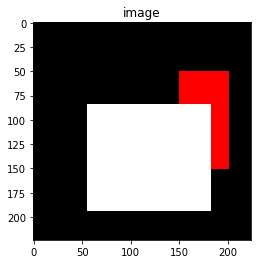

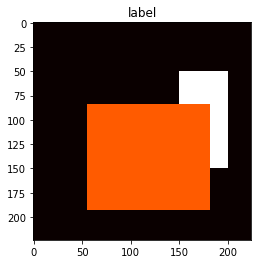

Image size (224, 224, 3)


In [55]:
class TrainingImage:
    """ 
    This class handles the creation of training
    images and the associated label image
    """
    #Colors classes    
    BLACK_CLASS = 0
    WHITE_CLASS = 1
    RED_CLASS = 2
    LIME_CLASS = 3
    BLUE_CLASS = 4
    YELLOW_CLASS = 5
    CYAN_CLASS = 6
    MAGENTA_CLASS = 7
    SILVER_CLASS = 8
    GRAY_CLASS = 9
    MAROON_CLASS = 10
    OLIVE_CLASS = 11
    GREEN_CLASS = 12
    PURPLE_CLASS = 13
    TEAL_CLASS = 14
    NAVY_CLASS = 15
    
    COLOR = {
        BLACK_CLASS : (0,0,0),
        WHITE_CLASS : (255,255,255),
        RED_CLASS : (255,0,0),
#         LIME_CLASS : (0,255,0),
#         BLUE_CLASS : (0,0,255),
#         YELLOW_CLASS : (255,255,0),
#         CYAN_CLASS : (0,255,255),
#         MAGENTA_CLASS : (255,0,255),
#         SILVER_CLASS : (192,192,192),
#         GRAY_CLASS : (128,128,128),
#         MAROON_CLASS : (128,0,0),
#         OLIVE_CLASS : (128,128,0),
#         GREEN_CLASS : (0,128,0),
#         PURPLE_CLASS : (128,0,128),
#         TEAL_CLASS : (0,128,128),
#         NAVY_CLASS : (0,0,128),
    }
    
    def __init__(self, size=(224,224, 3), backgd_color_class=BLACK_CLASS):
        self.size = size
        self.createImageBackground(backgd_color_class)
        
    def clear(self):
        self.image = np.zeros(self.size, dtype=np.uint8)
        self.label = np.zeros(self.size[0:2] + (len(TrainingImage.COLOR.keys()), ) , dtype=np.uint8)
        
    def createImageBackground(self, backgd_color_class):
        self.backgd_color_class = backgd_color_class
        self.clear()
        for channel in range(0, 3):
            self.image[:,:,channel] = TrainingImage.COLOR[self.backgd_color_class][channel]
        self.label[:,:, self.backgd_color_class] = 1
    
    def createRectangle(self, pt1, pt2, color_class=WHITE_CLASS):
        cv2.rectangle(self.image, 
                      pt1[::-1], pt2[::-1], TrainingImage.COLOR[color_class], thickness=cv2.FILLED)
        self.label[pt1[0]:pt2[0],pt1[1]:pt2[1], :] =  0 # Clear exisiting labels in target position
        self.label[pt1[0]:pt2[0],pt1[1]:pt2[1], color_class] =  1
        
    def addRandRectangle(self, color_class=WHITE_CLASS):
        image_size = self.image.shape
        pt1 = (random.randint(0, 150), random.randint(0, 100))
        pt2 = (random.randint(pt1[0]+50, image_size[0]-1), random.randint(pt1[1]+50, image_size[1]-1))
        self.createRectangle( pt1, pt2, color_class=color_class)

image_size = (224,224, 3)
trainim = TrainingImage(size=image_size , backgd_color_class=TrainingImage.BLACK_CLASS)
trainim.createRectangle( (50,150) , (150,200), color_class=TrainingImage.RED_CLASS)
trainim.addRandRectangle(TrainingImage.WHITE_CLASS)

# Plot background 
plt.imshow(trainim.image)
plt.title('image')
plt.show()

# Plot background 
#plt.imshow(trainim.label[:,:,11:14])
plt.imshow(trainim.label.argmax(axis=2), cmap='hot')
plt.title('label')
plt.show()

print('Image size {}'.format(trainim.image.shape))

In [79]:
# Generate color training dataset
from functools import reduce


NUM_TRAIN = 512
num_classes = len(TrainingImage.COLOR.keys())
image_size = (224,224, 3)
label_size = (224,224, num_classes)
size_in_memory = 1
image_mem = reduce(lambda a,b : a*b ,image_size, 1)
label_mem = reduce(lambda a,b : a*b ,label_size, 1)
total_train_mem = NUM_TRAIN * (image_mem + label_mem)
print('Total size of the use of memory : {}MB'.format(total_train_mem/(1024*1024)))

X_TRAIN_SIZE = (NUM_TRAIN,) + image_size
Y_TRAIN_SIZE = (NUM_TRAIN,) + image_size[0:2] + (num_classes, )
X_train = np.zeros(X_TRAIN_SIZE, dtype=np.uint8)
y_train = np.zeros(Y_TRAIN_SIZE, dtype=np.uint8)

trainim = TrainingImage(size=image_size)

for i in range(NUM_TRAIN):
    trainim.createImageBackground(TrainingImage.BLACK_CLASS)
    trainim.addRandRectangle(color_class=random.randint(1, num_classes-1))
    
    X_train[i] = trainim.image
    y_train[i] = trainim.label



Total size of the use of memory : 147.0MB


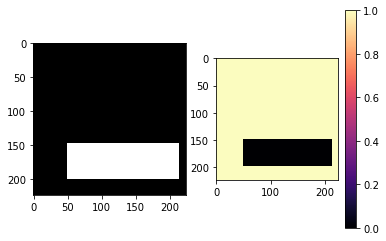

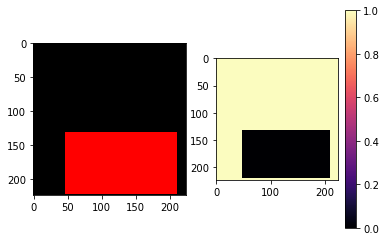

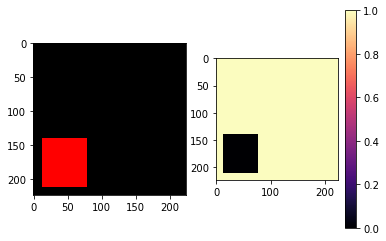

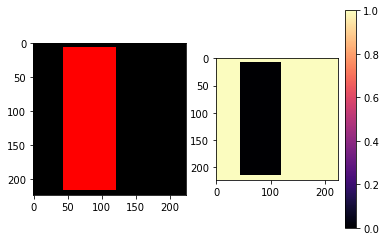

In [80]:
# Plot color evaluation dataset

for idx in range(3,7):

    fig = plt.figure(1)
    ax = fig.add_subplot(1,2,1)
    imsh = ax.imshow( X_train[idx], cmap='magma')

    ax = fig.add_subplot(1,2,2)
    imsh = ax.imshow( y_train[idx,:,:,0], cmap='magma')
    plt.colorbar(imsh)
    plt.show()






# Model
The original paper uses VGG for implementing the detector.


TODO : Will try experimenting with Xception and MobileNet  
https://keras.io/applications/#usage-examples-for-image-classification-models


In [5]:
# Extract features from an arbitrary intermediate layer with VGG19

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3),pooling=None, include_top=False)


print('Pre-trained model loaded.')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()


Using TensorFlow backend.


Pre-trained model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)  

In [6]:
# Get input dimensions
input_height = base_model.layers[0].input_shape[1]
input_width = base_model.layers[0].input_shape[2]

In [145]:
# Extract pooling layers out of VGG-16
num_classes = len(TrainingImage.COLOR.keys())


from keras.layers import Dense, Conv2D, UpSampling2D, Activation
from keras.layers import Conv2DTranspose, Add, Flatten, Lambda
from keras.layers import BatchNormalization, Reshape, Permute, Dropout
from keras import backend as K
from keras import regularizers



def UpLayer(num_classes, activation_layer, layer):
    simpleUpSample = True
    if not simpleUpSample :
        return Conv2DTranspose(num_classes, (3, 3), activation=activation_layer,
                            padding='same', strides=(2,2)  )(layer)
    else:
        return UpSampling2D()(layer)

activation_layer = 'elu'

# Layer 5
layer_5_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_5_1x1',
               activation=activation_layer)(base_model.get_layer('block5_pool').output)

up_layer_5 = UpLayer(num_classes, activation_layer, layer_5_1x1)

#up_layer_5_bn = BatchNormalization(axis=3, name='up_layer_5_bn')(up_layer_5)

# Layer 4
layer_4_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_4_1x1',
               activation=activation_layer)(base_model.get_layer('block4_pool').output)

merge_4_and_5 = Add()([up_layer_5, layer_4_1x1])


up_layer_4_and_5 = Conv2DTranspose(num_classes, (3, 3), activation=activation_layer,
                            padding='same', strides=(2,2))(merge_4_and_5)

up_layer_4_and_5 = BatchNormalization(axis=3, name='up_layer_4_and_5_bn')(up_layer_4_and_5)

# Layer 3
layer_3_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_3_1x1',
               activation=activation_layer)(base_model.get_layer('block3_pool').output)

merge_3_to_5 = Add()([up_layer_4_and_5, layer_3_1x1])

up_layer_3_to_5 = UpLayer(num_classes, activation_layer, merge_3_to_5)



# Layer 2
layer_2_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_2_1x1',
               activation=activation_layer)(base_model.get_layer('block2_pool').output)

merge_2_to_5 = Add()([up_layer_3_to_5, layer_2_1x1])



up_layer_2_to_5 =UpLayer(num_classes, activation_layer,merge_2_to_5)


up_layer_2_to_5 = BatchNormalization(axis=3, 
                                        name='up_layer_2_to_5_bn')(up_layer_2_to_5)

# Layer 1
layer_1_1x1 = Conv2D(num_classes, 1, padding='same', name='convpool_1_1x1',
               activation=activation_layer)(base_model.get_layer('block1_pool').output)

merge_1_to_5 = Add()([up_layer_2_to_5, layer_1_1x1])

up_layer_1_to_5 =UpLayer(num_classes, activation_layer, merge_1_to_5)

# Final layer
final_1_1x1 = Conv2D(num_classes, 1, padding='same', name='conv_1_1x1',
               activation=activation_layer)(base_model.get_layer('block1_conv1').output)

final_merge = Add()([final_1_1x1, up_layer_1_to_5])

def depth_softmax(matrix):
    """ The softmax activation function doesnt seeem to perform as well as the dice coeff """
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    sum_sig = K.sum(sigmoided_matrix, axis=3)
    sum_sig_reshaped = K.reshape(sum_sig,(-1,input_height,input_height,1))
    repeat = num_classes
    sum_sigmoided_repeated = K.repeat_elements(sum_sig_reshaped, repeat, axis=3)
    softmax_matrix = sigmoided_matrix / sum_sigmoided_repeated
    return softmax_matrix


seg_out = Lambda(depth_softmax, name='seg_out')(final_merge)

# Build a classifier model to put on top of the convolutional model

# model = Model(inputs=base_model.input, outputs=seg_out)

# https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/9d0fb65d67334dc332816bcb30d317c2de8b9137/train.py#L23

def dice_coef(y_true, y_pred):
    smooth = 1.0e-3
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return - K.log(1 + dice_coef(y_true, y_pred))


model = Model(inputs=base_model.input, outputs=final_merge)



from keras.utils import plot_model
plot_model(model, to_file='model.png')

#for i in model.layers:
#    print(i.trainable)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [146]:
from keras import optimizers
optimizer_selected = optimizers.Adam(lr=1e-3)

#model.compile(optimizer=optimizer_selected, loss='categorical_crossentropy')
model.compile(optimizer=optimizer_selected, loss=dice_coef_loss, metrics=[dice_coef])

class_weight = {TrainingImage.BLACK_CLASS: 1.0, TrainingImage.WHITE_CLASS: 3.0, TrainingImage.RED_CLASS: 3.0}


history = model.fit(x=X_train, y=y_train, batch_size=20, epochs=4, 
                    validation_split=0.0, validation_data=None, shuffle=True,
                    class_weight=None, sample_weight=None, initial_epoch=0,
                    steps_per_epoch=None, validation_steps=None)


Epoch 1/4
512/512 [==============================] - 9s 18ms/step - loss: -0.3666 - dice_coef: 0.4466
Epoch 2/4
512/512 [==============================] - 7s 13ms/step - loss: -0.5864 - dice_coef: 0.8068
Epoch 3/4
512/512 [==============================] - 7s 13ms/step - loss: -0.9519 - dice_coef: 1.6009
Epoch 4/4
512/512 [==============================] - 7s 13ms/step - loss: -1.0876 - dice_coef: 1.9676


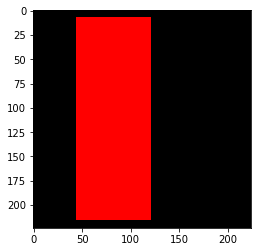

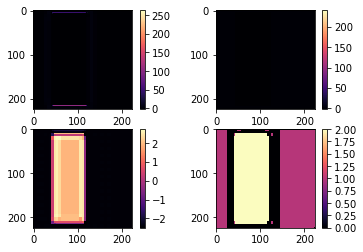

In [147]:
# Plot loss function
# plt.plot(history.epoch,history.history['loss'])
# plt.legend(('loss'))
# plt.grid('on')
# plt.show()

img = X_train[6]
seg= model.predict(img.reshape(1,224,224,3))

seg = seg.reshape(224,224, num_classes)

seg_classes=seg.argmax(axis=2)

plt.imshow(img)
plt.show()

fig = plt.figure(1)
fig.clf()
ax = fig.add_subplot(2,2,1)
imsh = ax.imshow( seg[:,:,0], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,2)
imsh = ax.imshow( seg[:,:,1], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,3)
imsh = ax.imshow( seg[:,:,2], cmap='magma')
fig.colorbar(imsh)

ax = fig.add_subplot(2,2,4)
imsh = ax.imshow( seg_classes, cmap='magma' )
fig.colorbar(imsh)
plt.show()



In [ ]:
plt.imshow(y_train[6][:,:,0])
plt.colorbar()
plt.show()